In [1]:
# !pip install numpy pandas scikit-learn torch torchvision torchaudio matplotlib tqdm --quiet

import os, re, glob, math, gc, warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# ========= USER CONFIG =========
BASE = r"E:\Collaboration Work\With Farooq\phm dataset\PHM Challange 2010 Milling"
TRAIN_CUTTERS = ["c1", "c4", "c6"]   # labeled
TEST_CUTTERS  = ["c2", "c3", "c5"]   # unlabeled

# Feature windows (change here to tune)
WIN = 4096          # samples per window  (≈82 ms @ 50 kHz)
HOP = 2048          # hop (overlap → better accuracy; 4096 = no overlap)
MAX_WINDOWS = 96    # truncate/pad time steps per cut (increase -> more context)

# Model / training
HIDDEN = 256        # LSTM hidden size (128–512 work well)
DROPOUT = 0.2
LR = 1e-3
EPOCHS = 35
LAMBDA_MONO = 0.3   # strength of monotonic penalty
MTL_WEIGHTS = (0.2, 0.2, 0.2, 1.0, 1.2)  # (f1,f2,f3,wear,RUL)
BATCH_SIZE = 8
VAL_RATIO = 0.15
SEED = 42
# ===============================

torch.manual_seed(SEED); np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [2]:
def read_wear_table(cutter_dir):
    # find wear csv
    cands = [p for p in glob.glob(os.path.join(cutter_dir, "*.csv"))
             if "wear" in os.path.basename(p).lower()]
    if not cands:
        raise FileNotFoundError(f"No wear csv in {cutter_dir}")
    wear_file = cands[0]

    # detect header
    raw0 = pd.read_csv(wear_file, sep=None, engine="python", nrows=5)
    try:
        v = pd.to_numeric(raw0.iloc[0,0], errors="coerce")
        use_header = bool(pd.isna(v))
    except Exception:
        use_header = True

    raw = (pd.read_csv(wear_file, sep=None, engine="python")
           if use_header else
           pd.read_csv(wear_file, sep=None, engine="python", header=None))
    raw.columns = [str(c).strip().lower() for c in raw.columns]

    def first_present(names):
        for n in names:
            if n in raw.columns: return n
        return None

    cut_col = first_present(["cut","cut_number","cut no","cut_no","c","index","id","0"])
    f1_col  = first_present(["flute_1","flute1","f1","flute 1","1"])
    f2_col  = first_present(["flute_2","flute2","f2","flute 2","2"])
    f3_col  = first_present(["flute_3","flute3","f3","flute 3","3"])

    if cut_col is None or f1_col is None or f2_col is None or f3_col is None:
        tmp = raw.copy().dropna(axis=1, how="all")
        assert tmp.shape[1] >= 4, "Wear file must have >=4 usable columns"
        tmp.columns = [f"col_{i}" for i in range(tmp.shape[1])]
        cut_col, f1_col, f2_col, f3_col = "col_0","col_1","col_2","col_3"
        raw = tmp

    cut_series = raw[cut_col].astype(str).str.extract(r"(\d+)", expand=False)
    cut_series = pd.to_numeric(cut_series, errors="coerce")

    f1 = pd.to_numeric(raw[f1_col], errors="coerce")
    f2 = pd.to_numeric(raw[f2_col], errors="coerce")
    f3 = pd.to_numeric(raw[f3_col], errors="coerce")

    df = pd.DataFrame({
        "Cut_Number": cut_series,
        "flute_1": f1, "flute_2": f2, "flute_3": f3
    }).dropna()
    df["Cut_Number"] = df["Cut_Number"].round().astype(int)

    # tool-level wear & per-cutter EOL
    df["wear_max"] = df[["flute_1","flute_2","flute_3"]].max(axis=1)
    EOL = float(df["wear_max"].max())

    # normalized targets [0,1]
    eps = 1e-9
    df["f1_norm"] = df["flute_1"] / (EOL + eps)
    df["f2_norm"] = df["flute_2"] / (EOL + eps)
    df["f3_norm"] = df["flute_3"] / (EOL + eps)
    df["wear_norm"] = df["wear_max"] / (EOL + eps)
    df["rul_norm"]  = 1.0 - df["wear_norm"]

    # raw RUL for metrics
    df["RUL"] = EOL - df["wear_max"]

    return df.sort_values("Cut_Number").reset_index(drop=True), EOL


def discover_cut_files(cutter_dir, cutter_id):
    all_csvs = glob.glob(os.path.join(cutter_dir, "**", "*.csv"), recursive=True)
    all_csvs = [p for p in all_csvs if "wear" not in os.path.basename(p).lower()]
    cuts = {}
    for p in all_csvs:
        name = os.path.basename(p).lower()
        m = re.search(rf"c[_-]?{cutter_id}[_-]?(\d+)\.csv$", name) or re.search(r"(\d+)\.csv$", name)
        if m:
            cuts[int(m.group(1))] = p
    return dict(sorted(cuts.items()))


In [3]:
def window_feats_1d(x):
    if x.size == 0:
        return np.zeros(7, dtype=np.float32)
    mean = x.mean()
    std  = x.std()
    rms  = float(np.sqrt(np.mean(x**2))) if x.size else 0.0
    mx   = float(x.max()) if x.size else 0.0
    crest = mx / (rms + 1e-9)

    X = np.fft.rfft(x, n=len(x))
    P = (np.abs(X)**2)
    power = float(P.sum())
    if power < 1e-12:
        centroid = 0.0
    else:
        freqs = np.fft.rfftfreq(len(x), d=1.0/50000.0)  # Fs=50 kHz
        centroid = float((freqs * P).sum() / power)

    return np.array([mean, std, rms, mx, power, centroid, crest], dtype=np.float32)

def extract_cut_windows(path):
    try:
        df = pd.read_csv(path, header=None, engine="c", low_memory=False)
    except Exception:
        df = pd.read_csv(path, header=None, engine="python", low_memory=False)
    df = df.dropna(axis=1, how="all")
    if df.shape[1] < 7:
        return None

    arr = df.iloc[:, :7].to_numpy(dtype=np.float32, copy=False)
    N = arr.shape[0]
    feats = []

    if N >= WIN:
        for start in range(0, N - WIN + 1, HOP):
            seg = arr[start:start+WIN, :]
            fwin = [window_feats_1d(seg[:, ch]) for ch in range(7)]
            feats.append(np.concatenate(fwin, axis=0))  # 7ch * 7feat = 49
            if len(feats) >= MAX_WINDOWS: break
    else:
        seg = arr
        fwin = [window_feats_1d(seg[:, ch]) for ch in range(7)]
        feats.append(np.concatenate(fwin, axis=0))

    F = np.stack(feats, axis=0)      # [T,49], T>=1
    T = F.shape[0]
    if T < MAX_WINDOWS:
        pad = np.zeros((MAX_WINDOWS - T, F.shape[1]), dtype=np.float32)
        F = np.concatenate([F, pad], axis=0)
    else:
        F = F[:MAX_WINDOWS]; T = MAX_WINDOWS
    return F, T


In [4]:
def build_index_for_cutters(cutters, labeled=True):
    index = []
    eol_map = {}
    for cname in cutters:
        cutter_dir = os.path.join(BASE, cname)
        cutter_id = int(re.findall(r"\d+", cname)[0])
        cut_files = discover_cut_files(cutter_dir, cutter_id)

        if labeled:
            wear_df, EOL = read_wear_table(cutter_dir)
            eol_map[cname] = EOL
            present = sorted(set(wear_df["Cut_Number"].astype(int)).intersection(cut_files.keys()))
            for cutn in present:
                row = wear_df.loc[wear_df["Cut_Number"]==cutn].iloc[0]
                y_norm = np.array([row["f1_norm"], row["f2_norm"], row["f3_norm"],
                                   row["wear_norm"], row["rul_norm"]], dtype=np.float32)
                y_raw  = np.array([row["flute_1"], row["flute_2"], row["flute_3"],
                                   row["wear_max"], row["RUL"]], dtype=np.float32)
                prev_cut = cutn-1 if (cutn-1) in present else None
                index.append({
                    "cutter": cname, "eol": EOL,
                    "cut_number": int(cutn),
                    "path": cut_files[int(cutn)],
                    "prev_path": cut_files[prev_cut] if prev_cut is not None else None,
                    "y_norm": y_norm, "y_raw": y_raw
                })
        else:
            present = sorted(cut_files.keys())
            for cutn in present:
                prev_cut = cutn-1 if (cutn-1) in present else None
                index.append({
                    "cutter": cname, "eol": None,
                    "cut_number": int(cutn),
                    "path": cut_files[int(cutn)],
                    "prev_path": cut_files[prev_cut] if prev_cut is not None else None,
                    "y_norm": None, "y_raw": None
                })
    return index, eol_map

train_index, train_eols = build_index_for_cutters(TRAIN_CUTTERS, labeled=True)
test_index,  _          = build_index_for_cutters(TEST_CUTTERS,  labeled=False)
print("Train samples:", len(train_index))
print("Test samples :", len(test_index))
print("Train EOLs   :", {k: round(v,2) for k,v in train_eols.items()})
EOL_REF = float(np.median(list(train_eols.values())))  # used only for approximate test plots
print("EOL_REF (median of train):", round(EOL_REF,2))


Train samples: 945
Test samples : 945
Train EOLs   : {'c1': 172.69, 'c4': 210.92, 'c6': 234.72}
EOL_REF (median of train): 210.92


In [5]:
class PHMWindowDataset(Dataset):
    def __init__(self, index, scaler=None, fit_scaler=False):
        self.index = index
        self.scaler = scaler
        if fit_scaler:
            stacks = []
            for it in tqdm(self.index, desc="Fitting scaler (train windows)"):
                out = extract_cut_windows(it["path"])
                if out is None: continue
                X, L = out
                stacks.append(X[:int(L)])
            S = np.concatenate(stacks, axis=0)
            self.scaler = StandardScaler().fit(S)

    def __len__(self): return len(self.index)

    def __getitem__(self, i):
        it = self.index[i]
        out = extract_cut_windows(it["path"])
        if out is None:
            X = np.zeros((MAX_WINDOWS, 49), dtype=np.float32); L = 1
        else:
            X, L = out; L = max(int(L), 1)
        if self.scaler is not None:
            X = self.scaler.transform(X)

        if it["prev_path"] is not None:
            outp = extract_cut_windows(it["prev_path"])
            if outp is None:
                Xp = np.zeros((MAX_WINDOWS, 49), dtype=np.float32); Lp = 1
            else:
                Xp, Lp = outp; Lp = max(int(Lp), 1)
            if self.scaler is not None:
                Xp = self.scaler.transform(Xp)
        else:
            Xp = np.zeros((MAX_WINDOWS, 49), dtype=np.float32); Lp = 0

        y_norm = it["y_norm"] if it["y_norm"] is not None else np.full((5,), np.nan, dtype=np.float32)
        y_raw  = it["y_raw"]  if it["y_raw"]  is not None else np.full((5,), np.nan, dtype=np.float32)
        eol    = np.float32(it["eol"]) if it["eol"] is not None else np.float32(np.nan)

        return (torch.tensor(X, dtype=torch.float32),
                torch.tensor(L, dtype=torch.long),
                torch.tensor(Xp, dtype=torch.float32),
                torch.tensor(Lp, dtype=torch.long),
                torch.tensor(y_norm, dtype=torch.float32),
                torch.tensor(y_raw,  dtype=torch.float32),
                torch.tensor(eol,    dtype=torch.float32),
                it["cut_number"], it["cutter"])

# Build datasets and loaders
full_train_ds = PHMWindowDataset(train_index, scaler=None, fit_scaler=True)
scaler = full_train_ds.scaler
val_n = int(len(full_train_ds) * VAL_RATIO)
train_n = len(full_train_ds) - val_n
train_ds, val_ds = torch.utils.data.random_split(full_train_ds, [train_n, val_n],
                                                 generator=torch.Generator().manual_seed(SEED))
test_ds  = PHMWindowDataset(test_index, scaler=scaler, fit_scaler=False)

def collate(batch):
    X,L,Xp,Lp,yn,yr,eol,cutn,cutter = zip(*batch)
    return (torch.stack(X), torch.stack(L),
            torch.stack(Xp), torch.stack(Lp),
            torch.stack(yn), torch.stack(yr),
            torch.stack(eol),
            np.array(cutn, dtype=int), np.array(cutter))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, collate_fn=collate)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate)

print("Batches -> train:", len(train_loader), "val:", len(val_loader), "test:", len(test_loader))


Fitting scaler (train windows): 100%|██████████| 945/945 [06:23<00:00,  2.47it/s]

Batches -> train: 101 val: 18 test: 119


In [8]:
class MultiTaskRULNet(nn.Module):
    def __init__(self, input_dim=49, hidden=HIDDEN, dropout=DROPOUT):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.head_f1 = nn.Linear(hidden, 1)
        self.head_f2 = nn.Linear(hidden, 1)
        self.head_f3 = nn.Linear(hidden, 1)
        self.head_max= nn.Linear(hidden, 1)
        self.head_rul= nn.Linear(hidden, 1)
        self.act = nn.Sigmoid()

    def forward(self, X, L):
        Lc = torch.clamp(L, min=1)
        packed = nn.utils.rnn.pack_padded_sequence(X, lengths=Lc.cpu(),
                                                   batch_first=True, enforce_sorted=False)
        _, (h, _) = self.lstm(packed)
        z = self.dropout(h[-1])
        f1 = self.act(self.head_f1(z)).squeeze(1)
        f2 = self.act(self.head_f2(z)).squeeze(1)
        f3 = self.act(self.head_f3(z)).squeeze(1)
        wmax = self.act(self.head_max(z)).squeeze(1)
        rul  = self.act(self.head_rul(z)).squeeze(1)
        return f1,f2,f3,wmax,rul

def multitask_loss_norm(preds, y_norm, mono=None, lambda_mono=LAMBDA_MONO, weights=MTL_WEIGHTS):
    f1,f2,f3,wmax,rul = preds
    mse = nn.MSELoss(reduction='none')
    loss = 0.0
    for pred, tgt, w in zip([f1,f2,f3,wmax,rul],
                            [y_norm[:,0],y_norm[:,1],y_norm[:,2],y_norm[:,3],y_norm[:,4]],
                            weights):
        mask = torch.isfinite(tgt).float()
        if mask.sum() > 0:
            l = mse(pred, tgt)
            loss += w * (l * mask).sum() / (mask.sum() + 1e-9)
    if mono is not None:
        wprev, mask_prev = mono
        relu = nn.ReLU()
        m = mask_prev.float()
        if m.sum() > 0:
            penalty = (relu(wprev - preds[3]) * m).sum() / (m.sum() + 1e-9)
            loss = loss + lambda_mono * penalty
    return loss


In [10]:
# ==== Train (denormalize for metrics; LR scheduler without 'verbose') ====
model = MultiTaskRULNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

# PyTorch build on your machine doesn't accept 'verbose', so omit it
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode='min', factor=0.5, patience=3
)

def current_lr(optimizer):
    return optimizer.param_groups[0]["lr"]

def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    tot=0.0; n=0
    ys=[]; ps=[]
    for X,L,Xp,Lp,yn,yr,eol,cutn,cutter in loader:
        X,L,Xp,Lp,yn,yr,eol = X.to(device),L.to(device),Xp.to(device),Lp.to(device),yn.to(device),yr.to(device),eol.to(device)
        if train: opt.zero_grad()

        preds = model(X,L)

        # prev for monotonic penalty (only where prev exists & label exists)
        with torch.no_grad():
            mask_prev = (Lp>0) & torch.isfinite(yn[:,3])
        mono=None
        if mask_prev.any():
            idx = mask_prev.nonzero(as_tuple=True)[0]
            Xp_sel, Lp_sel = Xp[idx], torch.clamp(Lp[idx], min=1)
            was_training = model.training
            model.eval()
            _,_,_,wprev,_ = model(Xp_sel, Lp_sel)   # normalized prev wear
            if was_training: model.train()
            wprev_full = torch.zeros_like(preds[3]); wprev_full[idx] = wprev
            mono = (wprev_full, mask_prev.to(device).float())

        loss = multitask_loss_norm(preds, yn, mono=mono)

        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        tot += float(loss.item()) * X.size(0); n += X.size(0)

        # metrics (de-normalize by each sample's EOL)
        with torch.no_grad():
            _,_,_,wmax_n,rul_n = preds
            wear_pred = wmax_n * eol
            rul_pred  = rul_n  * eol
            ys.append(yr[:,3:5].cpu().numpy())  # [wear_raw, RUL_raw]
            ps.append(torch.stack([wear_pred, rul_pred],1).cpu().numpy())

    Y = np.vstack(ys); P = np.vstack(ps)
    mw = np.isfinite(Y[:,0]); mr = np.isfinite(Y[:,1])
    wear_rmse = math.sqrt(mean_squared_error(Y[mw,0], P[mw,0])) if mw.any() else float('nan')
    wear_r2   = r2_score(Y[mw,0], P[mw,0])                       if mw.any() else float('nan')
    rul_rmse  = math.sqrt(mean_squared_error(Y[mr,1], P[mr,1]))  if mr.any() else float('nan')
    rul_r2    = r2_score(Y[mr,1], P[mr,1])                       if mr.any() else float('nan')
    return tot/n, wear_rmse, wear_r2, rul_rmse, rul_r2

best = 1e18
last_lr = current_lr(opt)
print(f"Start LR: {last_lr:.2e}")

for ep in range(1, EPOCHS+1):
    tr = run_epoch(train_loader, train=True)
    va = run_epoch(val_loader,   train=False)
    print(f"Epoch {ep:02d} | train loss {tr[0]:.2f} | wear RMSE {tr[1]:.2f} R² {tr[2]:.3f} | "
          f"val wear RMSE {va[1]:.2f} R² {va[2]:.3f} | val RUL RMSE {va[3]:.2f} R² {va[4]:.3f}")

    # plateau scheduler on validation score (sum of RMSEs)
    score = (0 if np.isnan(va[1]) else va[1]) + (0 if np.isnan(va[3]) else va[3])
    sched.step(score)
    new_lr = current_lr(opt)
    if new_lr < last_lr:
        print(f"  ↘ LR reduced: {last_lr:.2e} → {new_lr:.2e}")
    last_lr = new_lr

    if score < best:
        best = score
        torch.save(model.state_dict(), "best_mtl_rul_norm.pt")
        # print("  saved best")


Start LR: 1.00e-03
Epoch 01 | train loss 0.02 | wear RMSE 15.98 R² 0.849 | val wear RMSE 10.86 R² 0.926 | val RUL RMSE 10.28 R² 0.936
Epoch 02 | train loss 0.01 | wear RMSE 10.91 R² 0.930 | val wear RMSE 11.48 R² 0.918 | val RUL RMSE 10.41 R² 0.934
Epoch 03 | train loss 0.01 | wear RMSE 9.23 R² 0.950 | val wear RMSE 9.33 R² 0.946 | val RUL RMSE 9.32 R² 0.947
Epoch 04 | train loss 0.01 | wear RMSE 8.98 R² 0.952 | val wear RMSE 7.57 R² 0.964 | val RUL RMSE 7.04 R² 0.970
Epoch 05 | train loss 0.01 | wear RMSE 7.86 R² 0.963 | val wear RMSE 7.74 R² 0.963 | val RUL RMSE 7.49 R² 0.966
Epoch 06 | train loss 0.01 | wear RMSE 7.96 R² 0.962 | val wear RMSE 6.80 R² 0.971 | val RUL RMSE 6.36 R² 0.975
Epoch 07 | train loss 0.01 | wear RMSE 7.64 R² 0.965 | val wear RMSE 7.45 R² 0.965 | val RUL RMSE 7.02 R² 0.970
Epoch 08 | train loss 0.01 | wear RMSE 7.69 R² 0.965 | val wear RMSE 6.97 R² 0.970 | val RUL RMSE 6.80 R² 0.972
Epoch 09 | train loss 0.01 | wear RMSE 7.67 R² 0.965 | val wear RMSE 6.78 R² 0.

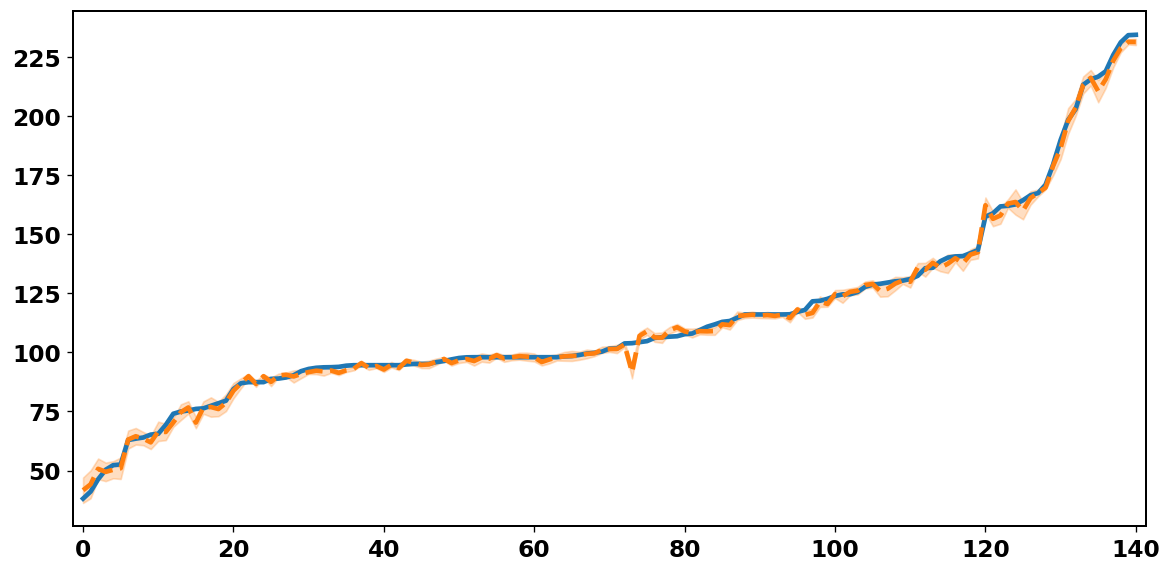

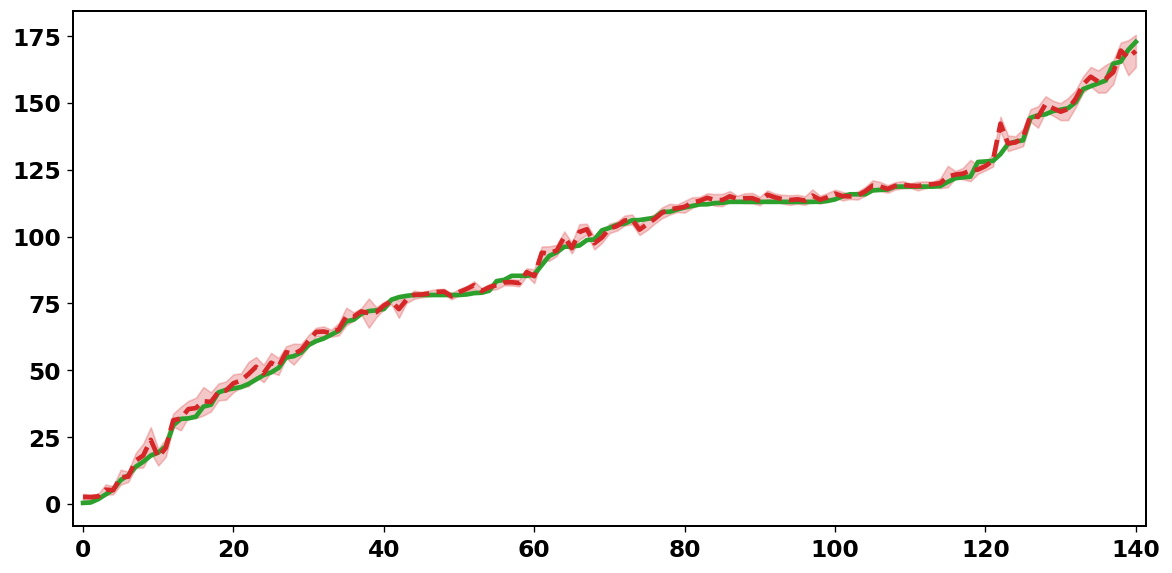

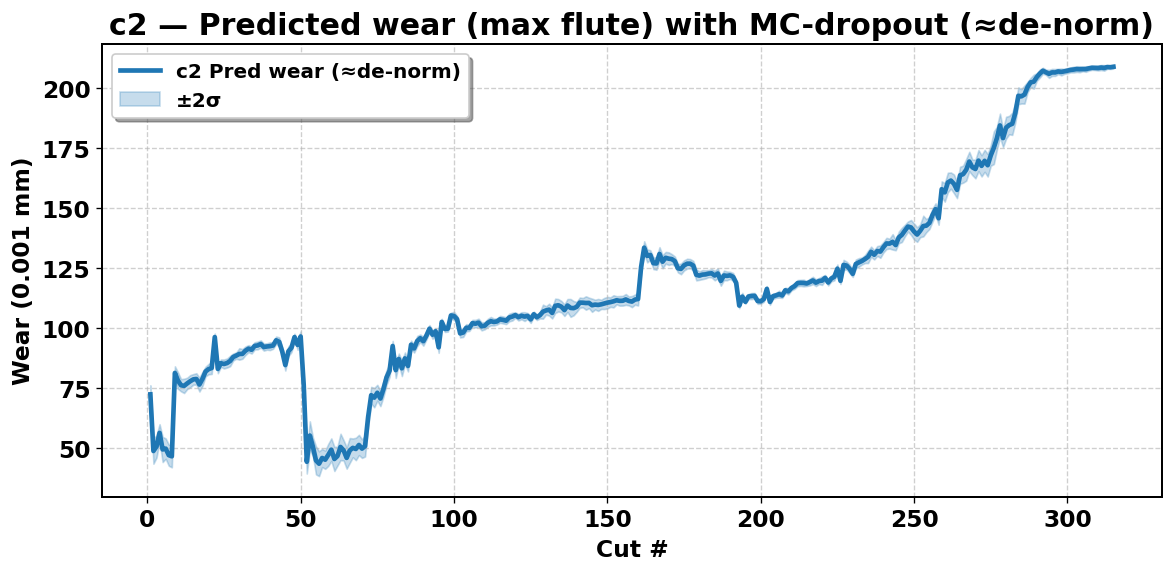

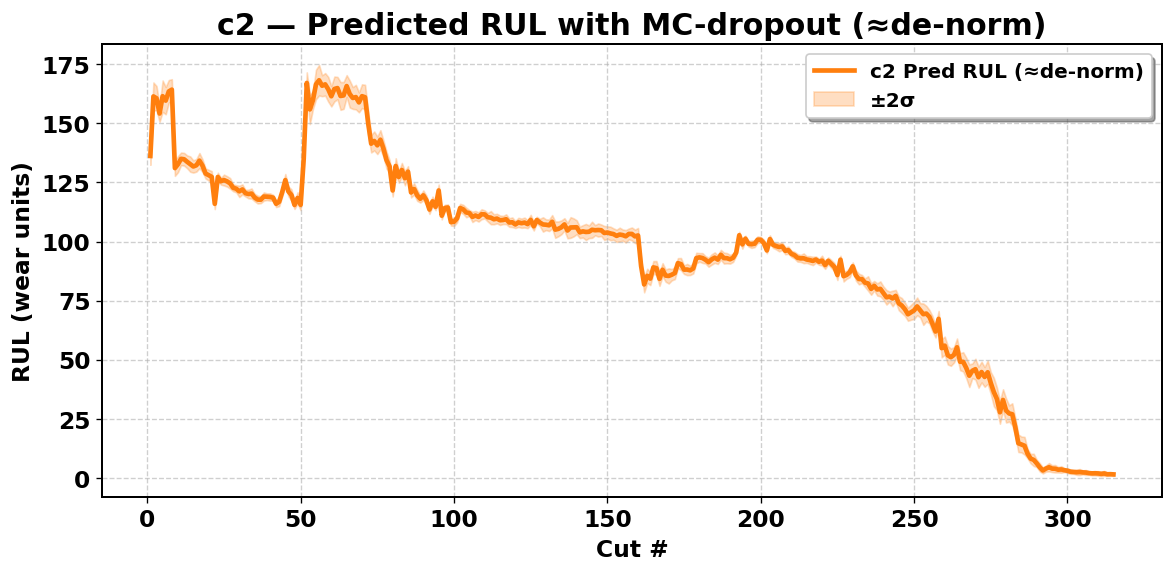

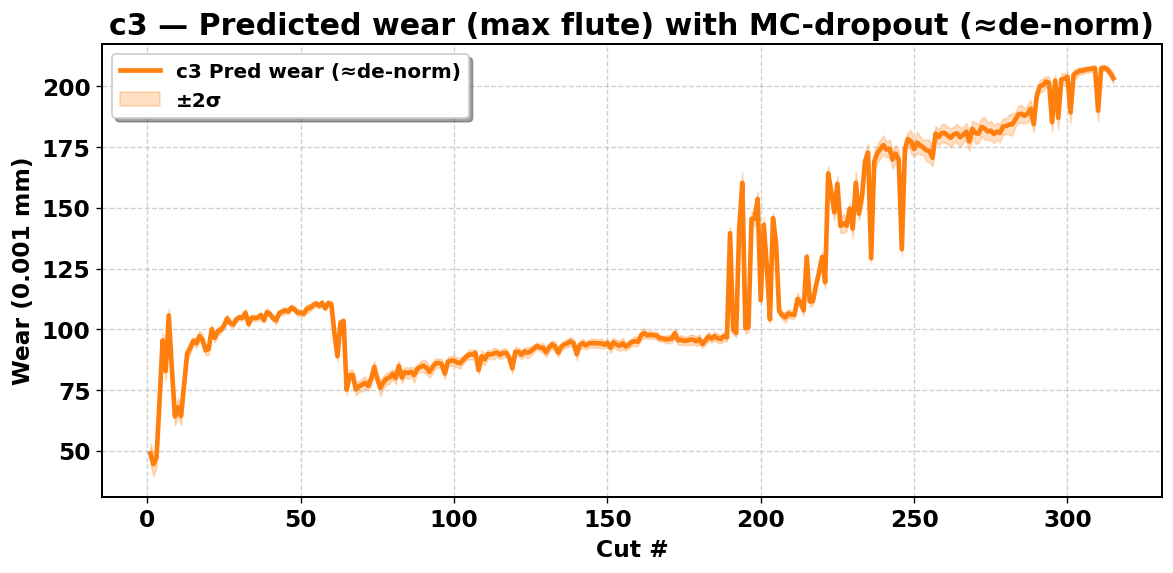

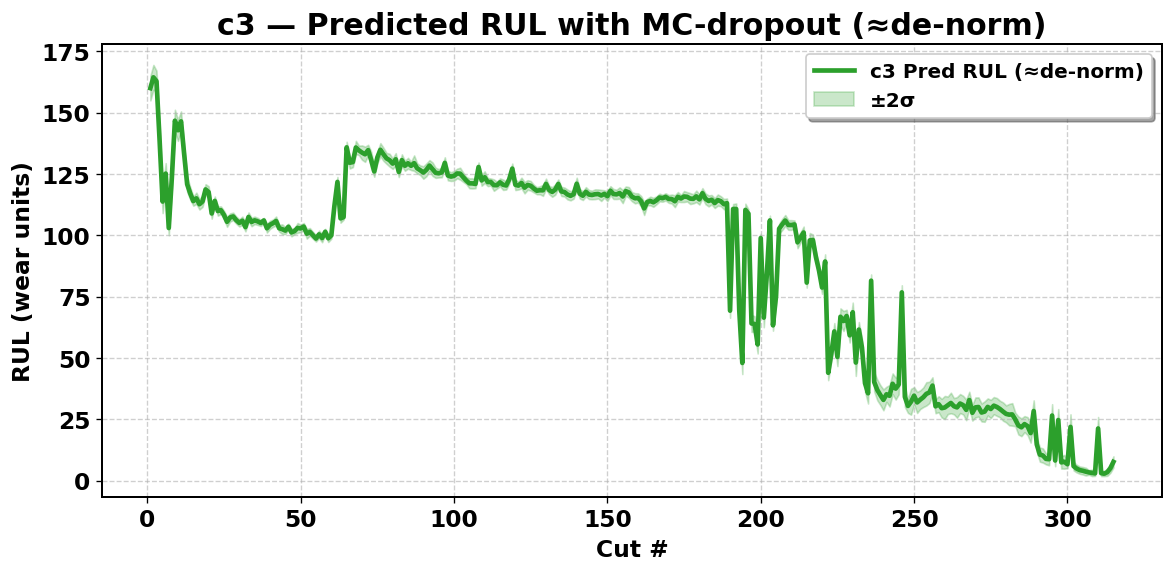

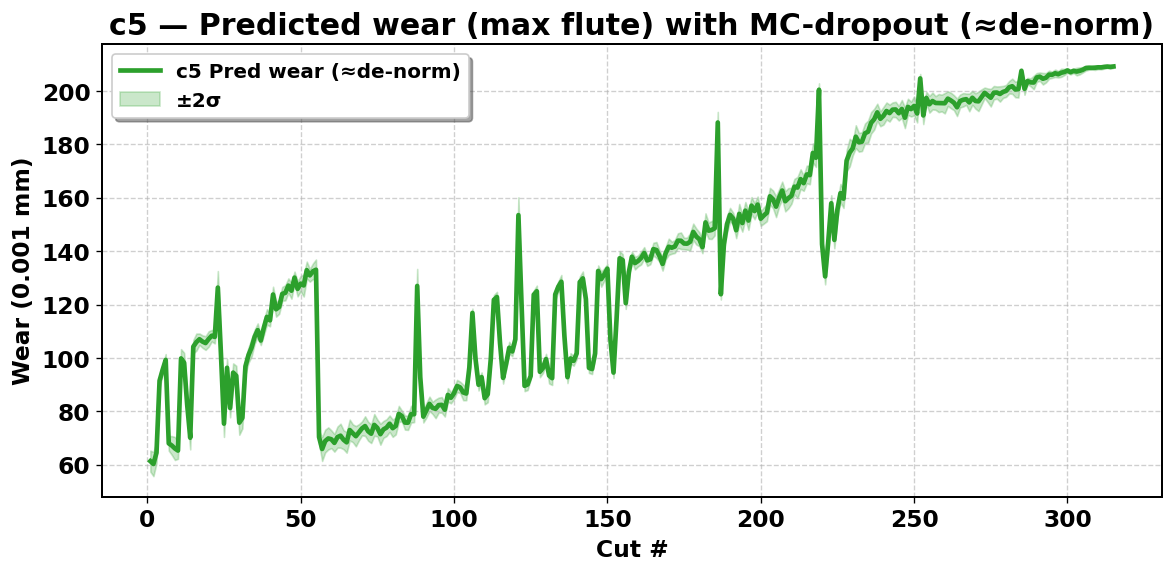

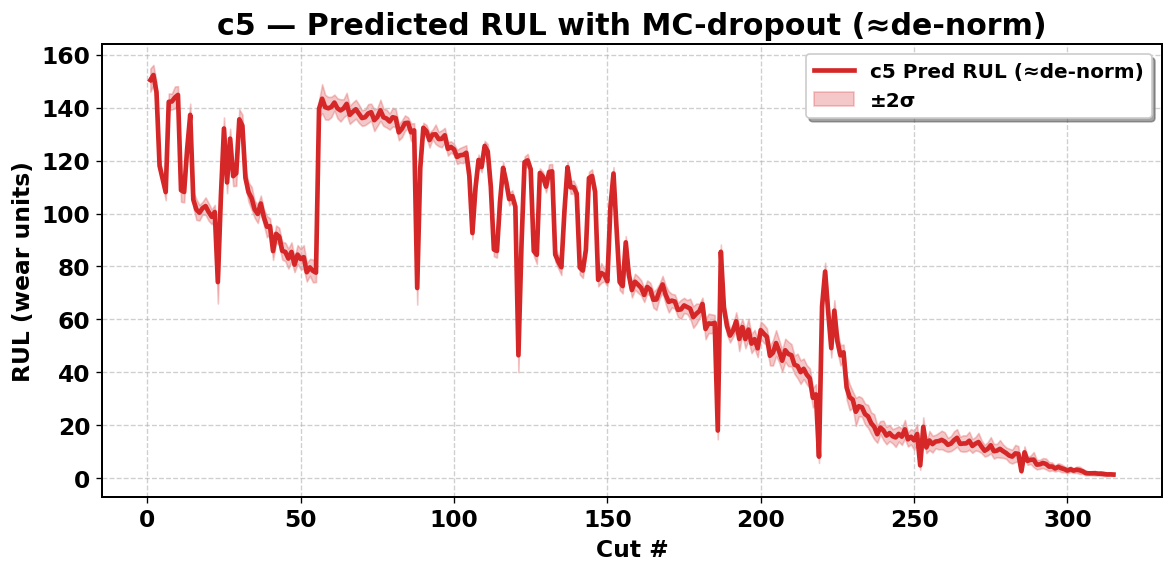

In [19]:
# ======= Global plotting style (apply once) =======
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cycler

# High-contrast color cycle
COLOR_CYCLE = [
    "tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple",
    "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"
]

mpl.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "figure.figsize": (10, 5),
    "font.size": 14,
    "font.weight": "bold",
    "axes.labelweight": "bold",
    "axes.titlesize": 18,
    "axes.titleweight": "bold",
    "axes.linewidth": 1.2,
    "axes.prop_cycle": cycler(color=COLOR_CYCLE),
    "legend.frameon": True,
    "legend.framealpha": 0.9,
    "legend.fontsize": 12,
    "grid.linewidth": 0.8,
})

def _beautify(ax, title, xlabel, ylabel, legend_loc="best"):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(loc=legend_loc, shadow=True)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)

def plot_truth_pred_band(x, y_true, y_pred, y_std, labels, colors=None, fname=None):
    """
    Generic: line for truth, dashed line for pred, shaded ±2σ band.
    labels = (truth_label, pred_label, band_label)
    """
    truth_label, pred_label, band_label = labels
    fig, ax = plt.subplots()

    # Choose colors (default: first two in cycle)
    c_truth = (colors[0] if colors else COLOR_CYCLE[0])
    c_pred  = (colors[1] if colors else COLOR_CYCLE[1])

    ax.plot(x, y_true, label=truth_label,
            linewidth=2.8, marker=None, color=c_truth)
    ax.plot(x, y_pred, label=pred_label,
            linewidth=2.8, linestyle="--", color=c_pred)
    ax.fill_between(x, y_pred - 2*y_std, y_pred + 2*y_std,
                    alpha=0.25, color=c_pred, label=band_label)

    ax.margins(x=0.01)
    plt.tight_layout()
    if fname:
        plt.savefig(fname, bbox_inches="tight")
    plt.show()

def plot_pred_band_only(x, y_pred, y_std, label_pred, band_label="±2σ", color=None, title="", xlabel="", ylabel="", fname=None):
    """
    For unlabeled test curves (no ground truth).
    """
    fig, ax = plt.subplots()
    c = color or COLOR_CYCLE[0]

    ax.plot(x, y_pred, label=label_pred,
            linewidth=2.8, linestyle="-", color=c)
    ax.fill_between(x, y_pred - 2*y_std, y_pred + 2*y_std,
                    alpha=0.25, color=c, label=band_label)

    _beautify(ax, title, xlabel, ylabel)
    plt.tight_layout()
    if fname:
        plt.savefig(fname, bbox_inches="tight")
    plt.show()


# ======= VALIDATION PLOTS (de-normalized) =======
# Wear
mask_w = np.isfinite(Yv[:, 0])
if mask_w.any():
    order_w = np.argsort(Yv[:, 0][mask_w])
    xw = np.arange(order_w.size)
    y_true_w = Yv[:, 0][mask_w][order_w]
    y_pred_w = Wm_v[mask_w][order_w]
    y_std_w  = Ws_v[mask_w][order_w]

    plot_truth_pred_band(
        x=xw,
        y_true=y_true_w,
        y_pred=y_pred_w,
        y_std=y_std_w,
        labels=("True wear", "Pred wear", "±2σ"),
        colors=["tab:blue", "tab:orange"],
    )
    plt.gca().set_title("Validation — Tool wear (max flute) with MC-dropout uncertainty")
    plt.gca().set_xlabel("Sample (sorted by truth)")
    plt.gca().set_ylabel("Wear (0.001 mm)")
    plt.gcf().savefig("val_wear_mc_dropout.png", bbox_inches="tight")
    plt.close()

# RUL
mask_r = np.isfinite(Yv[:, 1])
if mask_r.any():
    order_r = np.argsort(Yv[:, 1][mask_r])
    xr = np.arange(order_r.size)
    y_true_r = Yv[:, 1][mask_r][order_r]
    y_pred_r = Rm_v[mask_r][order_r]
    y_std_r  = Rs_v[mask_r][order_r]

    plot_truth_pred_band(
        x=xr,
        y_true=y_true_r,
        y_pred=y_pred_r,
        y_std=y_std_r,
        labels=("True RUL", "Pred RUL", "±2σ"),
        colors=["tab:green", "tab:red"],
    )
    plt.gca().set_title("Validation — RUL with MC-dropout uncertainty")
    plt.gca().set_xlabel("Sample (sorted by truth)")
    plt.gca().set_ylabel("RUL (wear units)")
    plt.gcf().savefig("val_rul_mc_dropout.png", bbox_inches="tight")
    plt.close()


# ======= TEST PLOTS (≈de-normalized display) =======
# We already computed pred_df above
# Per-cutter plots with stable distinct colors per series
for idx, cname in enumerate(TEST_CUTTERS):
    dd = pred_df[pred_df["cutter"] == cname]
    if dd.empty:
        continue

    x = dd["cut_number"].values

    # Wear (approx)
    mu_w = dd["wear_approx"].values
    sd_w = dd["wear_approx_std"].values
    color_w = COLOR_CYCLE[idx % len(COLOR_CYCLE)]

    plot_pred_band_only(
        x=x,
        y_pred=mu_w,
        y_std=sd_w,
        label_pred=f"{cname} Pred wear (≈de-norm)",
        band_label="±2σ",
        color=color_w,
        title=f"{cname} — Predicted wear (max flute) with MC-dropout (≈de-norm)",
        xlabel="Cut #",
        ylabel="Wear (0.001 mm)",
        fname=f"test_{cname}_wear_mc_dropout.png",
    )

    # RUL (approx)
    mu_r = dd["rul_approx"].values
    sd_r = dd["rul_approx_std"].values
    color_r = COLOR_CYCLE[(idx+1) % len(COLOR_CYCLE)]

    plot_pred_band_only(
        x=x,
        y_pred=mu_r,
        y_std=sd_r,
        label_pred=f"{cname} Pred RUL (≈de-norm)",
        band_label="±2σ",
        color=color_r,
        title=f"{cname} — Predicted RUL with MC-dropout (≈de-norm)",
        xlabel="Cut #",
        ylabel="RUL (wear units)",
        fname=f"test_{cname}_rul_mc_dropout.png",
    )


In [12]:
# === LOCO CV: train on two cutters, validate on the held-out labeled cutter ===
def make_loaders_for_cutters(train_cutters, val_cutters):
    train_index, _ = build_index_for_cutters(train_cutters, labeled=True)
    val_index,   _ = build_index_for_cutters(val_cutters,   labeled=True)

    train_ds_full = PHMWindowDataset(train_index, scaler=None, fit_scaler=True)
    scaler = train_ds_full.scaler
    train_loader = DataLoader(train_ds_full, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, collate_fn=collate)

    val_ds = PHMWindowDataset(val_index, scaler=scaler, fit_scaler=False)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate)
    return train_loader, val_loader

def train_one_fold(train_loader, val_loader, epochs=25):
    model = MultiTaskRULNet().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3)
    best, last_lr = 1e18, opt.param_groups[0]["lr"]

    for ep in range(1, epochs+1):
        tr = run_epoch(train_loader, train=True)
        va = run_epoch(val_loader,   train=False)
        score = (0 if np.isnan(va[1]) else va[1]) + (0 if np.isnan(va[3]) else va[3])
        sched.step(score)
        if opt.param_groups[0]["lr"] < last_lr:
            print(f"  ↘ LR {last_lr:.2e} → {opt.param_groups[0]['lr']:.2e}")
            last_lr = opt.param_groups[0]["lr"]
        if score < best:
            best = score
            torch.save(model.state_dict(), "best_loco.pt")
        print(f"Epoch {ep:02d} | train loss {tr[0]:.2f} | val wear RMSE {va[1]:.2f} R² {va[2]:.3f} | val RUL RMSE {va[3]:.2f} R² {va[4]:.3f}")
    model.load_state_dict(torch.load("best_loco.pt", map_location=device))
    return model

# Run 3 folds
loco_results = []
for val_cutter in TRAIN_CUTTERS:
    train_cutters = [c for c in TRAIN_CUTTERS if c != val_cutter]
    print(f"\n=== LOCO: validate on {val_cutter}, train on {train_cutters} ===")
    tr_loader, va_loader = make_loaders_for_cutters(train_cutters, [val_cutter])
    model = train_one_fold(tr_loader, va_loader, epochs=25)
    # MC metrics on the held-out cutter
    Yv, Wm_v, Ws_v, Rm_v, Rs_v, IDv, EOLv, Mv = mc_predict_loader(va_loader, n_samples=25, is_test=False)
    loco_results.append((val_cutter, Mv))
    print(f"LOCO {val_cutter}: {Mv}")

print("\nLOCO summary:")
for cutter, M in loco_results:
    print(cutter, "→", M)



=== LOCO: validate on c1, train on ['c4', 'c6'] ===


Fitting scaler (train windows): 100%|██████████| 630/630 [02:07<00:00,  4.93it/s]


Epoch 01 | train loss 0.00 | val wear RMSE 4.04 R² 0.979 | val RUL RMSE 3.68 R² 0.982
Epoch 02 | train loss 0.00 | val wear RMSE 3.74 R² 0.982 | val RUL RMSE 3.56 R² 0.984
Epoch 03 | train loss 0.00 | val wear RMSE 3.67 R² 0.983 | val RUL RMSE 3.62 R² 0.983
Epoch 04 | train loss 0.00 | val wear RMSE 3.86 R² 0.981 | val RUL RMSE 3.80 R² 0.981
Epoch 05 | train loss 0.00 | val wear RMSE 4.23 R² 0.977 | val RUL RMSE 4.34 R² 0.976
Epoch 06 | train loss 0.00 | val wear RMSE 4.13 R² 0.978 | val RUL RMSE 4.22 R² 0.977
  ↘ LR 1.00e-03 → 5.00e-04
Epoch 07 | train loss 0.00 | val wear RMSE 3.82 R² 0.981 | val RUL RMSE 3.89 R² 0.980
Epoch 08 | train loss 0.00 | val wear RMSE 4.02 R² 0.979 | val RUL RMSE 4.16 R² 0.978
Epoch 09 | train loss 0.00 | val wear RMSE 3.82 R² 0.981 | val RUL RMSE 4.16 R² 0.978
Epoch 10 | train loss 0.00 | val wear RMSE 3.85 R² 0.981 | val RUL RMSE 3.98 R² 0.980
  ↘ LR 5.00e-04 → 2.50e-04
Epoch 11 | train loss 0.00 | val wear RMSE 4.04 R² 0.979 | val RUL RMSE 4.10 R² 0.978


Fitting scaler (train windows): 100%|██████████| 630/630 [02:13<00:00,  4.71it/s]


Epoch 01 | train loss 0.13 | val wear RMSE 35.62 R² 0.146 | val RUL RMSE 36.93 R² 0.082
Epoch 02 | train loss 0.13 | val wear RMSE 35.62 R² 0.146 | val RUL RMSE 36.93 R² 0.082
Epoch 03 | train loss 0.13 | val wear RMSE 35.62 R² 0.146 | val RUL RMSE 36.93 R² 0.082
Epoch 04 | train loss 0.13 | val wear RMSE 35.62 R² 0.146 | val RUL RMSE 36.93 R² 0.082
  ↘ LR 1.00e-03 → 5.00e-04
Epoch 05 | train loss 0.13 | val wear RMSE 35.62 R² 0.146 | val RUL RMSE 36.93 R² 0.082
Epoch 06 | train loss 0.13 | val wear RMSE 35.62 R² 0.146 | val RUL RMSE 36.93 R² 0.082
Epoch 07 | train loss 0.13 | val wear RMSE 35.62 R² 0.146 | val RUL RMSE 36.93 R² 0.082
Epoch 08 | train loss 0.13 | val wear RMSE 35.62 R² 0.146 | val RUL RMSE 36.93 R² 0.082
  ↘ LR 5.00e-04 → 2.50e-04
Epoch 09 | train loss 0.13 | val wear RMSE 35.62 R² 0.146 | val RUL RMSE 36.93 R² 0.082
Epoch 10 | train loss 0.13 | val wear RMSE 35.62 R² 0.146 | val RUL RMSE 36.93 R² 0.082
Epoch 11 | train loss 0.13 | val wear RMSE 35.62 R² 0.146 | val RU

Fitting scaler (train windows): 100%|██████████| 630/630 [02:18<00:00,  4.55it/s]


Epoch 01 | train loss 0.11 | val wear RMSE 50.60 R² -0.173 | val RUL RMSE 55.27 R² -0.400
Epoch 02 | train loss 0.11 | val wear RMSE 50.60 R² -0.173 | val RUL RMSE 55.27 R² -0.400
Epoch 03 | train loss 0.11 | val wear RMSE 50.60 R² -0.173 | val RUL RMSE 55.27 R² -0.400
Epoch 04 | train loss 0.11 | val wear RMSE 50.60 R² -0.173 | val RUL RMSE 55.27 R² -0.400
  ↘ LR 1.00e-03 → 5.00e-04
Epoch 05 | train loss 0.11 | val wear RMSE 50.60 R² -0.173 | val RUL RMSE 55.27 R² -0.400
Epoch 06 | train loss 0.11 | val wear RMSE 50.60 R² -0.173 | val RUL RMSE 55.27 R² -0.400
Epoch 07 | train loss 0.11 | val wear RMSE 50.60 R² -0.173 | val RUL RMSE 55.27 R² -0.400
Epoch 08 | train loss 0.11 | val wear RMSE 50.60 R² -0.173 | val RUL RMSE 55.27 R² -0.400
  ↘ LR 5.00e-04 → 2.50e-04
Epoch 09 | train loss 0.11 | val wear RMSE 50.60 R² -0.173 | val RUL RMSE 55.27 R² -0.400
Epoch 10 | train loss 0.11 | val wear RMSE 50.60 R² -0.173 | val RUL RMSE 55.27 R² -0.400
Epoch 11 | train loss 0.11 | val wear RMSE 50.

In [13]:
def coverage_report(Y_true, mu, sd, which=0, ks=(0.5,1.0,1.5,2.0), label="wear"):
    mask = np.isfinite(Y_true[:,which])
    y = Y_true[mask,which]; m = mu[mask]; s = sd[mask]
    print(f"\nCalibration for {label}:")
    for k in ks:
        cov = np.mean(np.abs(y-m) <= k*s)
        print(f"  Coverage within ±{k}σ: {cov*100:.1f}%")

# Run on your existing VAL arrays (from mc_predict_loader on val_loader)
coverage_report(Yv, Wm_v, Ws_v, which=0, label="wear")
coverage_report(Yv, Rm_v, Rs_v, which=1, label="RUL")



Calibration for wear:
  Coverage within ±0.5σ: 4.1%
  Coverage within ±1.0σ: 7.3%
  Coverage within ±1.5σ: 12.7%
  Coverage within ±2.0σ: 18.1%

Calibration for RUL:
  Coverage within ±0.5σ: 8.6%
  Coverage within ±1.0σ: 13.7%
  Coverage within ±1.5σ: 16.8%
  Coverage within ±2.0σ: 19.4%


Saved: test_RUL_in_cuts_estimated.csv


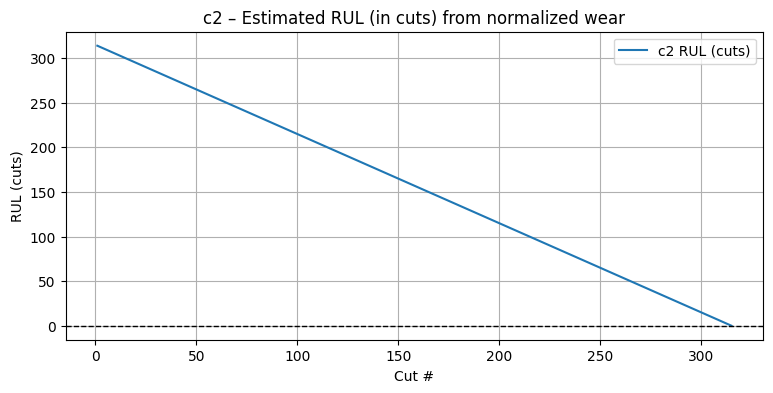

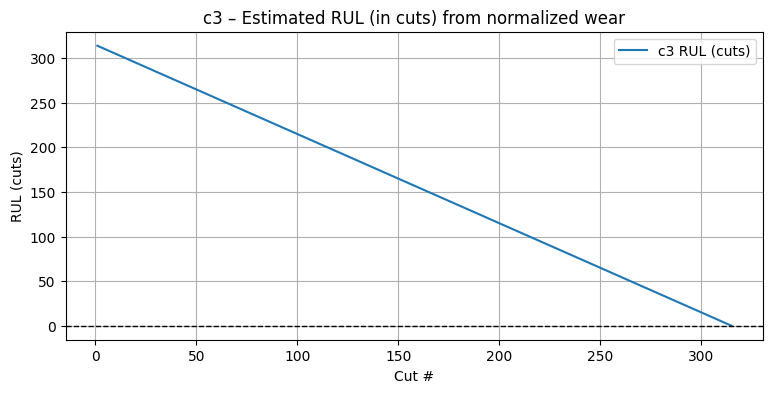

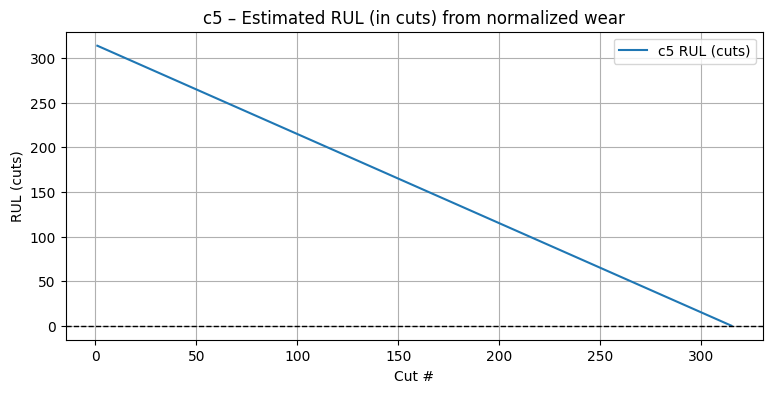

In [14]:
# 1) Get normalized predictions for TEST (you already have this earlier, but re-run if needed)
Yt, Wn_t, Ws_t, Rn_t, Rs_t, IDt, EOLt, _ = mc_predict_loader(test_loader, n_samples=25, is_test=True)
test_pred_norm = pd.DataFrame({
    "cutter": IDt[:,1],
    "cut_number": IDt[:,0].astype(int),
    "wear_norm_pred": Wn_t,
    "wear_norm_std": Ws_t,
    "rul_norm_pred": Rn_t,
    "rul_norm_std": Rs_t,
}).sort_values(["cutter","cut_number"]).reset_index(drop=True)

# 2) Fit exponential model and produce RUL in cuts
def fit_failure_time_from_norm(cuts, wnorm, target=0.99, min_points=20):
    cuts = np.asarray(cuts, dtype=float)
    w = np.clip(np.asarray(wnorm, dtype=float), 1e-6, target-1e-4)
    mask = (w > 1e-6) & (w < target-1e-4)
    if mask.sum() < min_points:
        return np.nan
    t = cuts[mask]; y = np.log(1.0 - w[mask])      # y ≈ -k t + b
    A = np.vstack([t, np.ones_like(t)]).T
    alpha, b = np.linalg.lstsq(A, y, rcond=None)[0]  # y = alpha t + b
    k = -alpha
    if k <= 0: return np.nan
    t_fail = (b - np.log(1.0 - target)) / k
    return float(t_fail)

def estimate_rul_cuts_for_cutter(df, target=0.99):
    d = df.sort_values("cut_number").copy()
    t_fail = fit_failure_time_from_norm(d["cut_number"].values, d["wear_norm_pred"].values, target=target)
    if not np.isfinite(t_fail):
        t_fail = float(d["cut_number"].max())  # fallback
    d["RUL_cuts_est"] = np.maximum(0.0, t_fail - d["cut_number"].values)
    d["t_fail_est"] = t_fail
    return d

all_rul = []
for cname, grp in test_pred_norm.groupby("cutter"):
    all_rul.append(estimate_rul_cuts_for_cutter(grp, target=0.99))
test_rul_cuts = pd.concat(all_rul, ignore_index=True)
test_rul_cuts.to_csv("test_RUL_in_cuts_estimated.csv", index=False)
print("Saved:", "test_RUL_in_cuts_estimated.csv")

# 3) Quick plots per test cutter (RUL in cuts)
for cname, d in test_rul_cuts.groupby("cutter"):
    plt.figure(figsize=(9,4))
    plt.plot(d["cut_number"], d["RUL_cuts_est"], label=f"{cname} RUL (cuts)")
    plt.axhline(0, ls="--", lw=1, color="k")
    plt.title(f"{cname} – Estimated RUL (in cuts) from normalized wear")
    plt.xlabel("Cut #"); plt.ylabel("RUL (cuts)"); plt.grid(True); plt.legend(); plt.show()
